### Load Data, drop empty Txt and Settings
----

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import svm
from sklearn.svm import SVC

In [26]:
## SETTINGS

# active models
SET_NN_active = False

SET_track_scores = True

SET_SVM_active = True

SET_datapath = "data_pp_sample.json"
SET_name_outputfile = "performance_290323_rs42.csv"

df = pd.read_json(SET_datapath, orient="columns")

df.drop(df[df.comment_text.str.len() == 0].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,comment_text,toxic,sentence_lengths
0,real value objective real value constant purch...,0,17
1,petition wikipedia unban virgin medium virgin ...,0,45
2,wikipedians indefinitely,0,2
3,love michael u got problem wit,0,6
4,good work expansion,0,3


### Word Embedding

----

#### TFidf Vectorizer

In [27]:
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=500)
X = vectorizer_tfidf.fit_transform(df["comment_text"].values.tolist()).toarray()
y = df['toxic'].values

### Split Data for Models
----

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (60100, 500)
X_test shape: (15025, 500)
y_train shape: (60100,)
y_test shape: (15025,)


### Train Models and get Scores

----

#### Try... Neural Network

In [30]:
if SET_NN_active:

    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten


    # convert labels to categorical data
    num_classes = 2
    input_shape = X_train.shape


    # define the model architecture
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['precission'])

    model.fit(X_train, y_train, batch_size=1, epochs=5, validation_data=(X_test, y_test))

In [31]:
def model_train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_tr = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("--------------------Training Performance---------------------")
    print(accuracy_score(y_train,y_pred_tr))
    print(classification_report(y_train,y_pred_tr))
    print("-------------------------------------------------------------")
    print("--------------------Testing Performance----------------------")
    print(accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.4g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

    if SET_track_scores:

        report = classification_report(y_test,y_pred, output_dict=True)
        # print(report)
        recall = report[str(1)]["recall"]
        precision = report[str(1)]["precision"]
        f1_score = report[str(1)]["f1-score"]

        # Save recall value in a CSV file
        with open(SET_name_outputfile, mode='a') as csv_file:
            fieldnames = ['Model', 'WordEmbedding', 'Precision', 'Recall', 'F1-Score']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

            # adds header in case csv is empty
            if csv_file.tell() == 0:
                writer.writeheader()

            writer.writerow({'Model': model.__class__.__name__, 'WordEmbedding': 'TFidf', 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score})

#### Naive Bayes:

--------------------Training Performance---------------------
0.706189683860233
              precision    recall  f1-score   support

           0       0.69      0.98      0.81     39141
           1       0.83      0.20      0.32     20959

    accuracy                           0.71     60100
   macro avg       0.76      0.59      0.57     60100
weighted avg       0.74      0.71      0.64     60100

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.7064226289517471
              precision    recall  f1-score   support

           0       0.69      0.98      0.81      9785
           1       0.85      0.19      0.31      5240

    accuracy                           0.71     15025
   macro avg       0.77      0.59      0.56     15025
weighted avg       0.75      0.71      0.64     15025



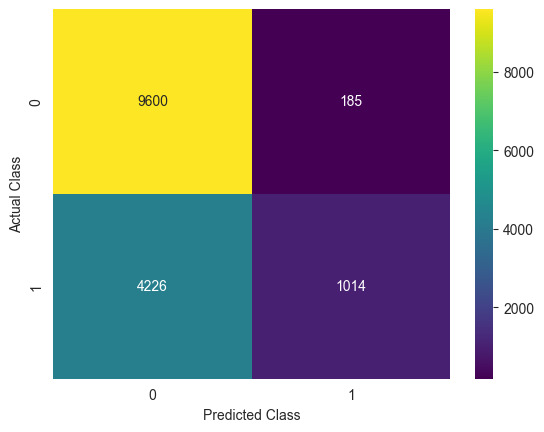

In [32]:
modelNB = MultinomialNB()
model_train(modelNB, X_train, X_test, y_train, y_test)

#### Support Vector Machine

[LibSVM]

C:\Users\Lea Keller\Documents\nlp_p2\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


--------------------Training Performance---------------------
0.5313311148086522
              precision    recall  f1-score   support

           0       0.71      0.47      0.57     39141
           1       0.39      0.65      0.49     20959

    accuracy                           0.53     60100
   macro avg       0.55      0.56      0.53     60100
weighted avg       0.60      0.53      0.54     60100

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.5202662229617304
              precision    recall  f1-score   support

           0       0.70      0.46      0.55      9785
           1       0.39      0.64      0.48      5240

    accuracy                           0.52     15025
   macro avg       0.54      0.55      0.52     15025
weighted avg       0.59      0.52      0.53     15025



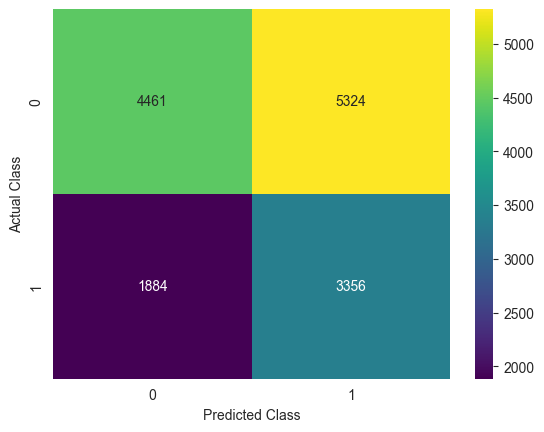

In [33]:
if SET_SVM_active:
    modelSVM = svm.SVC(kernel = 'linear', max_iter = 10000, verbose=True)
    model_train(modelSVM, X_train, X_test, y_train, y_test)

#### Logistic Regression (Best Model) :

--------------------Training Performance---------------------
0.707720465890183
              precision    recall  f1-score   support

           0       0.70      0.97      0.81     39141
           1       0.82      0.21      0.33     20959

    accuracy                           0.71     60100
   macro avg       0.76      0.59      0.57     60100
weighted avg       0.74      0.71      0.65     60100

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.7083527454242928
              precision    recall  f1-score   support

           0       0.70      0.98      0.81      9785
           1       0.83      0.21      0.33      5240

    accuracy                           0.71     15025
   macro avg       0.76      0.59      0.57     15025
weighted avg       0.74      0.71      0.65     15025



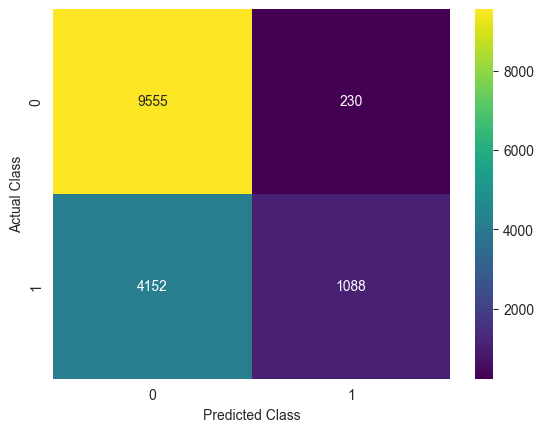

In [34]:
modelLR = LogisticRegression(max_iter=1000)
model_train(modelLR, X_train, X_test, y_train, y_test)

#### Random forest:

--------------------Training Performance---------------------
0.697720465890183
              precision    recall  f1-score   support

           0       0.68      1.00      0.81     39141
           1       0.96      0.14      0.24     20959

    accuracy                           0.70     60100
   macro avg       0.82      0.57      0.53     60100
weighted avg       0.78      0.70      0.61     60100

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.6923128119800332
              precision    recall  f1-score   support

           0       0.68      0.99      0.81      9785
           1       0.93      0.13      0.22      5240

    accuracy                           0.69     15025
   macro avg       0.80      0.56      0.52     15025
weighted avg       0.77      0.69      0.60     15025



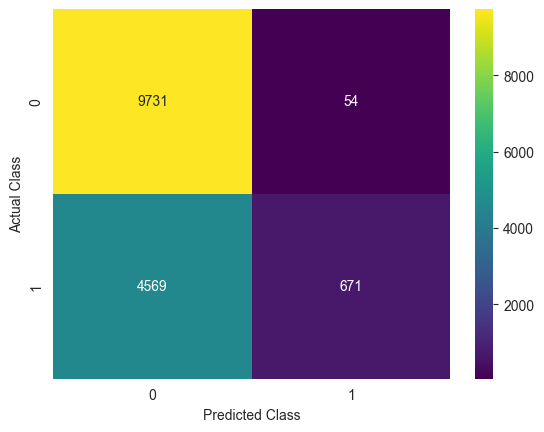

In [35]:
model = RandomForestClassifier(n_estimators=100,max_depth=10,max_features='sqrt')
model_train(model, X_train, X_test, y_train, y_test)

In [36]:
print("finished")

finished
